<a href="https://colab.research.google.com/github/ankita1120/almabetter/blob/publicBranch/FedEx_Logistics_Performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Summary

Business Context:

FedEx Logistics manages a global supply chain, handling shipments across multiple regions, industries, and countries. The dataset provides insights into key logistics processes such as purchase orders (POs), shipment methods, vendor agreements (INCO terms), delivery schedules, and product details. Efficient management of these operations is critical to minimizing freight costs, improving delivery timelines, and enhancing customer satisfaction.

With the rise of eCommerce and global distribution, FedEx must continuously optimize its logistics network. Analyzing this dataset helps identify inefficiencies, streamline operations, and reduce costs while maintaining service excellence.

## Dataset Description
The dataset includes:

Purchase Orders (POs) – Details of shipments, including suppliers and order quantities.
Shipment Methods – Various transportation modes (air, sea, road) and associated costs.
INCO Terms – Vendor agreements defining shipping responsibilities.
Delivery Schedules – Expected vs. actual delivery performance.
Product Details – Categories, item descriptions, and dosage forms.


# Import libraries

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


## Upload Dataset


In [4]:
# Upload Dataset
df = pd.read_csv('/content/SCMS_Delivery_History_Dataset.csv')

print(df.head())

   ID Project Code            PQ # PO / SO # ASN/DN #        Country  \
0   1   100-CI-T01  Pre-PQ Process    SCMS-4    ASN-8  Côte d'Ivoire   
1   3   108-VN-T01  Pre-PQ Process   SCMS-13   ASN-85        Vietnam   
2   4   100-CI-T01  Pre-PQ Process   SCMS-20   ASN-14  Côte d'Ivoire   
3  15   108-VN-T01  Pre-PQ Process   SCMS-78   ASN-50        Vietnam   
4  16   108-VN-T01  Pre-PQ Process   SCMS-81   ASN-55        Vietnam   

  Managed By  Fulfill Via Vendor INCO Term Shipment Mode  ...  \
0   PMO - US  Direct Drop              EXW           Air  ...   
1   PMO - US  Direct Drop              EXW           Air  ...   
2   PMO - US  Direct Drop              FCA           Air  ...   
3   PMO - US  Direct Drop              EXW           Air  ...   
4   PMO - US  Direct Drop              EXW           Air  ...   

  Unit of Measure (Per Pack) Line Item Quantity Line Item Value Pack Price  \
0                         30                 19           551.0      29.00   
1                   

## Display basic information

In [5]:
# Display basic information
print("DataSet Shape:" , df.shape)
print("DataSet Info:" , df.info())
print("DataSet Describe:" , df.describe())
print("\n Misssing values:" , df.isnull().sum())

DataSet Shape: (10324, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       103

# Handle missing values

In [6]:
# Handle missing values for Freight Cost
if 'Freight Cost (USD)' in df.columns:
    # Attempt to convert the column to numeric, handling errors
    df['Freight Cost (USD)'] = pd.to_numeric(df['Freight Cost (USD)'], errors='coerce')

    if df['Freight Cost (USD)'].notna().sum() > 0:
        df['Freight Cost (USD)'].fillna(df['Freight Cost (USD)'].mean(), inplace=True)
    else:
        print("Warning: 'Freight Cost (USD)' column contains only NaN values.")
else:
    print("Warning: 'Freight Cost (USD)' column not found in DataFrame.")

# Rename columns for consistency
df.rename(columns={'PO Sent to Vendor Date': 'Order_Date',
                   'Delivered to Client Date': 'Delivery_Date'}, inplace=True)

# Convert date columns safely
date_columns = ['Order_Date', 'Delivery_Date']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    else:
        print(f"Warning: '{col}' column not found in DataFrame.")

# Ensure both Order_Date and Delivery_Date exist before calculating duration
if 'Order_Date' in df.columns and 'Delivery_Date' in df.columns:
    df["Delivery_Duration"] = (df["Delivery_Date"] - df["Order_Date"]).dt.days
    df["Delivery_Duration"] = df["Delivery_Duration"].fillna(-1)  # Assign -1 to invalid durations
else:
    print("Warning: One or both date columns are missing.")

# Remove duplicates
df.drop_duplicates(inplace=True)

# Basic Statistics
print("\nBasic Statistics:\n", df.describe())


<ipython-input-6-1e12f51391cc>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Freight Cost (USD)'].fillna(df['Freight Cost (USD)'].mean(), inplace=True)
<ipython-input-6-1e12f51391cc>:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-6-1e12f51391cc>:21: UserWarning: Could not infer format, so each element will be parse


Basic Statistics:
                  ID                     Order_Date  \
count  10324.000000                           4592   
mean   51098.968229  2012-01-25 07:21:13.170731776   
min        1.000000            2006-04-19 00:00:00   
25%    12795.750000            2010-02-04 00:00:00   
50%    57540.500000            2012-06-07 00:00:00   
75%    83648.250000            2014-04-30 00:00:00   
max    86823.000000            2015-08-24 00:00:00   
std    31944.332496                            NaN   

                       Delivery_Date  Unit of Measure (Per Pack)  \
count                          10324                10324.000000   
mean   2011-09-28 14:56:34.963192576                   77.990895   
min              2006-05-02 00:00:00                    1.000000   
25%              2009-09-01 00:00:00                   30.000000   
50%              2011-11-25 00:00:00                   60.000000   
75%              2013-12-23 00:00:00                   90.000000   
max              

# EDA
# Shipment Method Analysis


<ipython-input-7-7c290613e326>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Shipment Mode", palette="coolwarm")


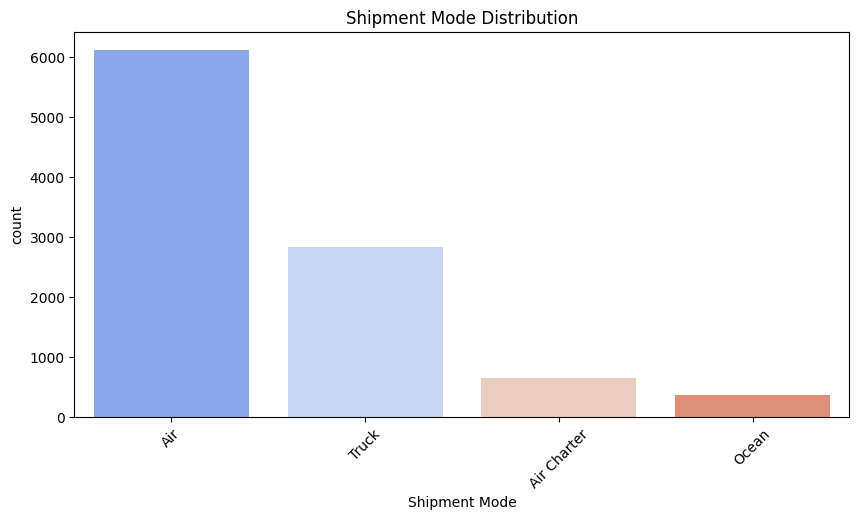

In [7]:
# Shipment Mode Analysis
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Shipment Mode", palette="coolwarm")
plt.title("Shipment Mode Distribution")
plt.xticks(rotation=45)
plt.show()

# Freight Cost Distribution

<ipython-input-8-a94cab7ff00a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Shipment Mode", y="Freight Cost (USD)", palette="viridis")


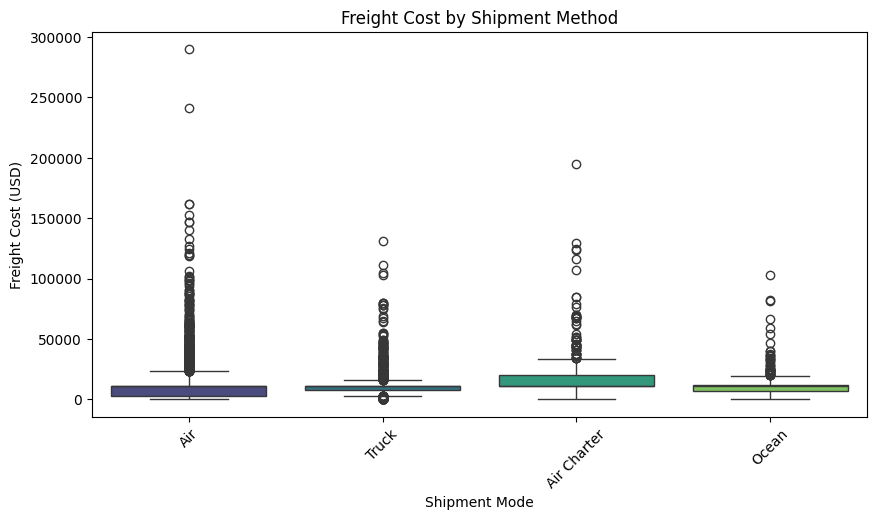

In [8]:
# Freight Cost Distribution
plt.figure(figsize=(10, 5))
# Changed 'Shipment_Method' to 'Shipment Mode'
sns.boxplot(data=df, x="Shipment Mode", y="Freight Cost (USD)", palette="viridis")
plt.title("Freight Cost by Shipment Method")
plt.xticks(rotation=45)
plt.show()

# Interactive Geo-Map of Shipments


In [9]:
# Create interactive shipment distribution map
fig = px.scatter_geo(df, locations="Country",
                     locationmode="country names",  # Uses country names instead of lat/lon
                     color="Shipment Mode",
                     size="Freight Cost (USD)",
                     hover_name="Country",
                     title="Shipment Distribution Map")

fig.show()

# Correlation Matrix


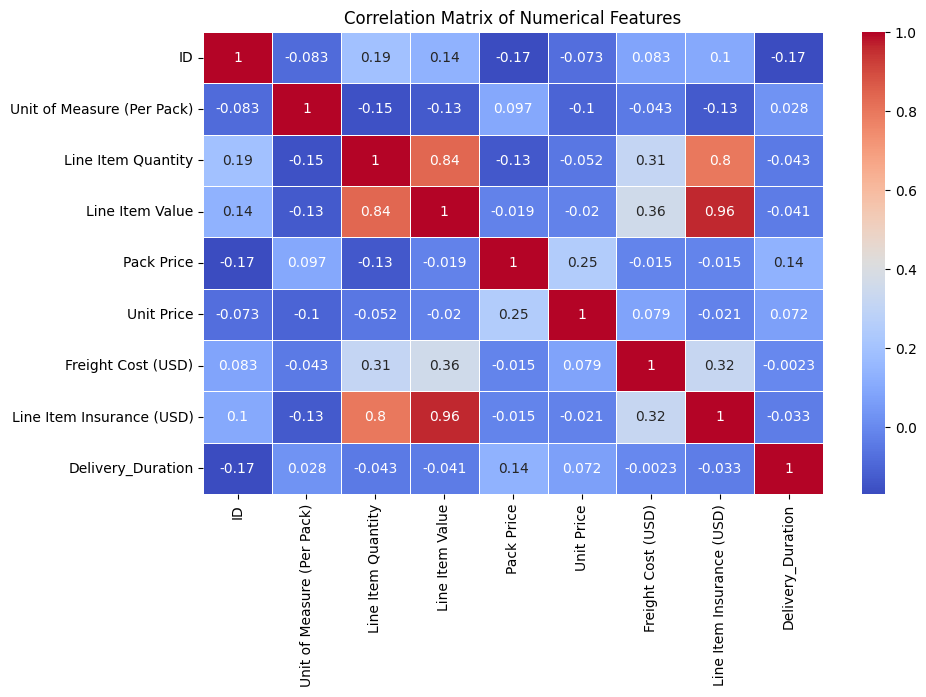

In [10]:
# Compute correlation matrix for numerical columns
numeric_df = df.select_dtypes(include=["number"])  # Selects only numeric columns
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [11]:
# Insights
print("\nKey Insights:")
print("- The most frequently used shipment mode is:", df["Shipment Mode"].mode()[0])
# Replace 'Delivery Time (Days)' with 'Delivery_Duration'
print("- Average delivery duration:", df["Delivery_Duration"].mean(), "days")
print("- Highest freight cost recorded:", df["Freight Cost (USD)"].max())


Key Insights:
- The most frequently used shipment mode is: Air
- Average delivery duration: 46.396067415730336 days
- Highest freight cost recorded: 289653.2
